In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
import time
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import import_ipynb
from Shape_mask_returner import pipeline_list
from load_images_sample_shape import load

importing Jupyter notebook from Shape_mask_returner.ipynb
importing Jupyter notebook from load_images_sample_shape.ipynb
importing Jupyter notebook from cluster_images_kmeans.ipynb
importing Jupyter notebook from crop_clustering.ipynb


In [2]:
data,labels=load()
X=pipeline_list(data)
data_dir = "C:/Users/Maximus/MANAS/AUVSI_Perception/ManasNotebooks/generated_data/shapes"

# some categories were not there in dataset so i had created my own in grayscale and that is why loaded it seperately
categories=['hexagon','heptagon','octagon','quartercircle']
for num,category in enumerate(categories):
        letter_path = os.path.join(data_dir , category)
        ##make path to each folder
        for path in tqdm(os.listdir(letter_path)[:500]):
            img = cv.cvtColor(cv.imread(os.path.join(letter_path ,path)),cv.COLOR_RGB2GRAY)
            X.append(img)
            labels.append(category)

100%|██████████| 500/500 [00:00<00:00, 1786.69it/s]
9it [00:02,  3.36it/s]
100%|██████████| 500/500 [00:01<00:00, 347.19it/s]


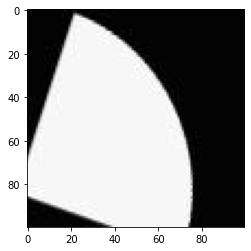

In [3]:
plt.imshow(X[-50],cmap='gray')

In [4]:
print(np.array(X).shape)

(6500, 100, 100)


In [5]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, Activation,Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D 

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input

In [6]:
import pandas as pd
print(np.array(labels).shape)
labels=pd.get_dummies(labels).to_numpy()
print(labels.shape)

(6500,)
(6500, 13)


In [7]:
X=np.array(X)
data=np.repeat(X[..., np.newaxis], 3, -1)
X_train, X_test, y_train, y_test = train_test_split(data,labels, test_size=0.1, random_state=42, shuffle=True)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(5850, 100, 100, 3) (650, 100, 100, 3) (5850, 13) (650, 13)


In [11]:
IMAGE_SIZE=100
input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
model = Sequential()
model.add(Xception(include_top = False, pooling = MaxPool2D,input_shape= input_shape, weights = 'imagenet'))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(1024, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(13, activation = 'softmax'))

In [12]:
model.summary()
optimizer = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay = 0.0)
model.compile(loss='categorical_crossentropy', optimizer = optimizer, metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 3, 3, 2048)        20861480  
_________________________________________________________________
flatten_1 (Flatten)          (None, 18432)             0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 18432)             73728     
_________________________________________________________________
dropout_3 (Dropout)          (None, 18432)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              18875392  
_________________________________________________________________
batch_normalization_11 (Batc (None, 1024)              4096      
_________________________________________________________________
dense_5 (Dense)              (None, 512)              

In [13]:
EPOCHS = 50
BATCH_SIZE = 64
annealer = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,
                                                patience=10, verbose=1, min_lr=1e-5)
checkpoint = tf.keras.callbacks.ModelCheckpoint('full_train_xception_shape.h5', verbose=1,
                                                save_best_only=True)

datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=360,
                        width_shift_range=0.1, height_shift_range=0.1, 
                        zoom_range=0.2, horizontal_flip=True, vertical_flip=True) w

datagen.fit(X_train)

history = model.fit(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
               steps_per_epoch=X_train.shape[0] // BATCH_SIZE, epochs=EPOCHS,verbose=1,
               callbacks=[annealer, checkpoint],
               validation_data=(X_test, y_test))

Epoch 1/50
91/91 [==============================] - 26s 223ms/step - loss: 3.0032 - accuracy: 0.1552 - val_loss: 1.8696 - val_accuracy: 0.4262

Epoch 00001: val_loss improved from inf to 1.86957, saving model to full_train_xception_shape.h5
Epoch 2/50
91/91 [==============================] - 18s 197ms/step - loss: 1.8136 - accuracy: 0.3797 - val_loss: 1.2435 - val_accuracy: 0.6292

Epoch 00002: val_loss improved from 1.86957 to 1.24345, saving model to full_train_xception_shape.h5
Epoch 3/50
91/91 [==============================] - 18s 197ms/step - loss: 1.2901 - accuracy: 0.5475 - val_loss: 0.6948 - val_accuracy: 0.7400

Epoch 00003: val_loss improved from 1.24345 to 0.69477, saving model to full_train_xception_shape.h5
Epoch 4/50
91/91 [==============================] - 18s 198ms/step - loss: 0.8926 - accuracy: 0.6887 - val_loss: 0.4434 - val_accuracy: 0.8338

Epoch 00004: val_loss improved from 0.69477 to 0.44343, saving model to full_train_xception_shape.h5
Epoch 5/50
91/91 [======